# Description of the problem and the approach taken

The problem is inspired from the  tensorflow tutorial:

[1] https://www.tensorflow.org/tutorials/generative/cvae  


in which the task is to generate images of handwritten digits by training a Variational Autoencoder on the well-known MNIST database. 
The objective of this worksheet is to modify the notebook so that, instead of generating images from the distribution of the MNIST dataset, it generates rows from the distribution of the US 1990 census

http://archive.ics.uci.edu/ml/datasets/US+Census+Data+%281990%29

The tutorial worksheet cannot be applied as it is to the US Census Database. The main difference is that in the former the variables are binomial - as they represent a pixel being black or white, whereas in the latter the variables are all categorical, thus having more than two levels. The problem has been studied in literature: the main references are

[2] Categorical Reparameterization with Gumbel-Softmax. Eric Jang, Shixiang Gu, Ben Poole 
https://arxiv.org/abs/1611.01144 

and 

[3] Generating Multi-Categorical Samples with Generative Adversarial Networks. Ramiro Camino, Christian Hammerschmidt, Radu State 
https://arxiv.org/abs/1807.01202


Following these references, the main modifications I applied to [1] are the following: 

- Adapt the cost function: the penalization term needs to be defined so that it can be applied to categorical variables, while retaining continuity and some smoothness. I followed the ideas in [2] to achieve this using Relaxed One Hot Encoding on categorical variables and using the categorical cross-entropy as loss function in place of ELBO, as done in [3]

- adapt the generative step: instead of sampling from a Bernoulli distribution from the latent space, I sampled from the aforementioned Relaxed One Hot Encoding distributions, following [2] .


# Import libraries

In [149]:
!pip install seaborn

In [150]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_probability as tfp 
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.metrics.regression import mean_squared_error
from IPython import display
from tensorflow.keras import backend as K
import seaborn as sns

from sklearn.model_selection import train_test_split

# read dataset and dummify it

In [6]:
df_full=pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990.data.txt")

For computational reasons, I take only 100.000 records (the training takes forever otherwise)

In [121]:
df= df_full.iloc[:,1:11].sample(n=100000, random_state=42)
all_variables =df.columns
var_levels = list(np.cumsum([len(df[var].unique()) for var in all_variables]))
count_all_dummies=var_levels[-1]

these are needed for the dummification and de-dummification 

In [122]:
var_value_list=[sorted(list(df[var].unique())) for var in all_variables]

In [123]:
var_levels = [0]+list(var_levels)

I one-hot encode the variables which are all categorical

In [124]:
def one_hot_enconding(df):
    df_encoded= pd.concat([pd.get_dummies(df[var], prefix=var) for var in df.columns], axis=1)
    return df_encoded

In [125]:
df_dummified =one_hot_enconding(df)

In [126]:
BATCH_SIZE = 100

In [127]:
train_df, test_df = train_test_split(df_dummified , test_size=0.3, random_state=42)

In [128]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_df.values).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_df.values).batch(BATCH_SIZE)

define Tensorflow probability distributions

In [129]:
RelaxedOneHotCategorical = tfp.distributions.RelaxedOneHotCategorical
KL = tfp.distributions.kl_divergence

I follow [2] to define the CatVAE class and the loss function. Note that I did not tune the parameters, for the sake of time. 
The network architecture resembles the one in the figure ([3]): 
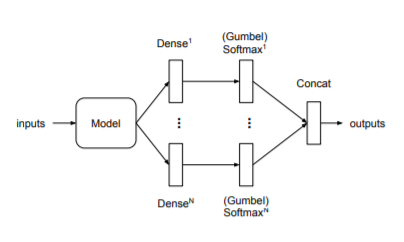

In [163]:
# define models for inference and generating over number of categorical 
# distributions with latent dimension
class CatVAE(tf.keras.Model):
    def __init__(self, latent_dim, num_dist,count_all_dummies):
        super(CatVAE, self).__init__()
        
        # latent dimensions
        self.latent_dim = latent_dim
        
        # number of distributions to sample from in latent space
        self.num_dist = num_dist
        
        # inference model to estimate the posterior p(z|x)
        self.inference_net = tf.keras.Sequential(
          [
          tf.keras.layers.InputLayer(input_shape=(count_all_dummies,)),
          tf.keras.layers.Dense(100, activation=tf.nn.relu),
          tf.keras.layers.Dense(50, activation=tf.nn.relu),
          # no activation for final layer
          tf.keras.layers.Dense(self.latent_dim*self.num_dist),
          tf.keras.layers.Reshape((-1, self.num_dist, self.latent_dim))])
        
        # generative model to estimate the likelihood p(x|z) for samples
        self.generative_net = tf.keras.Sequential(
          [
          tf.keras.layers.InputLayer(input_shape=(self.num_dist, self.latent_dim,)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(50, activation=tf.nn.relu),
          tf.keras.layers.Dense(100, activation=tf.nn.relu),
          # no activation for final layer
          tf.keras.layers.Dense(count_all_dummies)])

    def encode(self, x):
        logits_z = self.inference_net(x)
        return logits_z

    def reparameterize(self, tau, logits_z):
        # generate latent sample using Gumbel-Softmax for categorical variables
        z = RelaxedOneHotCategorical(tau,logits_z).sample()
        z_hard = tf.cast(tf.one_hot(tf.argmax(z,-1), self.latent_dim), z.dtype)
        z = tf.stop_gradient(z_hard - z) + z
        return z

    def decode(self, z):
        logits_x = self.generative_net(z)
        return logits_x


In [164]:
def kl_mod(x, y):
    div=0
    for i in range(1, len(var_levels)):
        X =  x[:,var_levels[i-1]:var_levels[i]]
        Y =  y[:,var_levels[i-1]:var_levels[i]]
        B= tf.math.divide(X,Y)
        div+=tf.reduce_mean(-tf.nn.softmax_cross_entropy_with_logits(X, B))
    return div

In [165]:
# define categorical vae loss function with hard prior
def CatVAE_loss(model, x, tau, var_levels=var_levels):
    logits_z = model.encode(x)
    z = model.reparameterize(tau, logits_z)
    logits_x = model.decode(z)
    pred = tf.concat([RelaxedOneHotCategorical(tau, logits=logits_x[:,var_levels[i-1]:var_levels[i]]).sample() for i in range(1,len(var_levels))], axis=1)
    KL_qp = kl_mod(tf.cast(x, 'float32'),pred)
    KL_qp_sum= tf.reduce_sum(KL_qp)
    loss = K.categorical_crossentropy(tf.cast(x, 'float32'), pred, axis=-1)
    y = tf.reduce_mean(loss - KL_qp)
    return y

In [166]:
def compute_apply_gradients(model, x, optimizer,tau):
    with tf.GradientTape() as tape:
        loss = CatVAE_loss(model, x,tau)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [167]:
# define constants for epochs, # of latent dimensions, # of distributions
# to sample from in latent space
# parameters are not tuned 
    
epochs = 10
latent_dim = 15
num_dist = 3
tau0 = 1.0
lr_init = 0.001
    
tau = tf.Variable(tau0, name = "temperature", trainable = True)
lr = tf.Variable(lr_init, name = "learning_rate", trainable=False)
    
optimizer = tf.optimizers.Adam(lr)

model = CatVAE(latent_dim, num_dist,count_all_dummies)
    
train_loss_results = []

In [168]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    print("running Epoch ", epoch)
    i=1
    for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer,tau)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(CatVAE_loss(model, test_x,tau))
    elbo = loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set LOSS: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))

Epoch: 10, Test set LOSS: 35.528907775878906, time elapse for current epoch 55.005828857421875


First we want to assess the predictiveness of the model: here by predictivness we mean the ability to correctly encode and decode the input. We thus compare the reconstruction with the actual observations. 

In [169]:
preds=pd.DataFrame(columns=test_df.columns).astype("int")
for t_x in test_dataset:
    logits_z = model.encode(tf.cast(t_x, "float32"))
    z = model.reparameterize(tau, logits_z)
    logits_x = model.decode(z)
    t = tf.concat([RelaxedOneHotCategorical(1, logits=logits_x[:,var_levels[i-1]:var_levels[i]]).sample() 
                       for i in range(1, len(var_levels))], axis=1)
    t_o_h = tf.concat([tf.one_hot(tf.argmax(t[:,var_levels[i-1]:var_levels[i]], axis=-1),
                           int(var_levels[i]-var_levels[i-1]))
                           for i in range(1, len(var_levels))], axis=1)
    
    preds=preds.append(pd.DataFrame(t_o_h.numpy().astype("int"),columns=test_df.columns))

In [170]:
aux=var_levels[:-1]
def dedummify(row, aux, var_value_list):
    pos=np.where(row==1)[0]
    relative_pos= np.subtract(pos,aux)
    return list(map( lambda x: var_value_list[x[0]][x[1]], enumerate(relative_pos)))
    

In [171]:
r = preds.apply(lambda x: dedummify(x,aux, var_value_list), axis=1)
preds_dedummified=pd.DataFrame(list(r), columns=all_variables)

In [172]:
tt = test_df.apply(lambda x: dedummify(x,aux, var_value_list), axis=1)
test_dedummified=pd.DataFrame(list(tt), columns=all_variables)

In [173]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [174]:
def get_performance_scores(test,sample):
    
    for cols in test.columns:
        print(cols)
        print(classification_report(test[cols],sample[cols]))
        conf=confusion_matrix(test[cols],sample[cols])
        try:
            chi2,pval, _ , _ =scs.chi2_contingency(conf)
            print("Chi-squared score:" , chi2)
            print("p-value:" , pval, "\n")
        except:
            print("Chi^2 test cannot be performed")
        print("confusion matrix: \n")
        
        print(conf)
        print("\n")

In [176]:
get_performance_scores(test_dedummified,preds_dedummified)

dAge
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       380
           1       0.95      0.94      0.94      5372
           2       0.61      0.65      0.63      2963
           3       0.76      0.77      0.77      4620
           4       0.90      0.86      0.88      4869
           5       0.75      0.71      0.73      3850
           6       0.65      0.72      0.69      4067
           7       0.79      0.77      0.78      3879

    accuracy                           0.78     30000
   macro avg       0.77      0.75      0.76     30000
weighted avg       0.79      0.78      0.79     30000

Chi-squared score: 118411.85446688335
p-value: 0.0 

confusion matrix: 

[[ 237  119   22    0    2    0    0    0]
 [  71 5030  268    1    1    1    0    0]
 [   4  168 1932  802   45   10    2    0]
 [   0    0  875 3544  148   43    6    4]
 [   4    0   78  229 4168  341   45    4]
 [   1    0   12   52  258 2730  704   93]
 [   0    0  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7019
           1       0.99      0.96      0.97      3022
           2       0.99      1.00      1.00     19959

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.99     30000
weighted avg       0.99      0.99      0.99     30000

Chi-squared score: 58027.1853231113
p-value: 0.0 

confusion matrix: 

[[ 7019     0     0]
 [    0  2888   134]
 [    2    39 19918]]


iDisabl2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7019
           1       0.97      0.98      0.97      2003
           2       1.00      1.00      1.00     20978

    accuracy                           1.00     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       1.00      1.00      1.00     30000

Chi-squared score: 58344.85851608483
p-value: 0.0 

confusion matrix: 

[[ 7018     0     1]

All in all, the performance of the model seems acceptable. Some classes which are very scarcely populated are almost never reconstructed correctly, but the accuracy of the reconstruction in each class is fair, with potential improvement with a larger training set and careful parameter tuning.

# Generation of a new sample and comparison with test set

Now we generate synthetic new samples using the generative component of the model. Thus, in the latent space we sample from the Relaxed One Hot Categorical based on the input data, we decode it and reconstruct. 
We follow the same procedure we followed during the training: we split the output of the last layer of the network into chunks, each of width equal to the number of levels of the variable that is one-hot encoded in the input, and fit a RelaxedOneHotCategorical into each and then convert this into a one hot encoding by taking the largest probability within each chunk with the argmax, which will be the predicted level of the output variable.


In [177]:
M = len(test_df)*num_dist
    
test_z = np.zeros((M,latent_dim))  
test_z[range(M),np.random.choice(latent_dim,M)] = 1  
test_z = np.reshape(test_z,[len(test_df), num_dist, latent_dim])

In [178]:
test_z

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [179]:
M = len(test_df)*num_dist
    
test_z = np.zeros((M,latent_dim))  
test_z[range(M),np.random.choice(latent_dim,M)] = 1  
test_z = np.reshape(test_z,[len(test_df), num_dist, latent_dim])
z = model.reparameterize(tau, tf.cast(test_z,"float32"))
logits_x = model.decode(z)
test_z = test_z.astype('float32')
    # generate sample images from prior (test_z)
        
sample = tf.concat([RelaxedOneHotCategorical(1, logits=logits_x[:,var_levels[i-1]:var_levels[i]]).sample() 
                       for i in range(1, len(var_levels))], axis=1)

t_o_h_sample = tf.concat([tf.one_hot(tf.argmax(sample[:,var_levels[i-1]:var_levels[i]], axis=-1),
                           int(var_levels[i]-var_levels[i-1]))
                           for i in range(1, len(var_levels))], axis=1)
                          
sample=pd.DataFrame(t_o_h_sample.numpy().astype("int"),columns=test_df.columns)

In [180]:
ss = sample.apply(lambda x: dedummify(x,aux, var_value_list), axis=1)
sample_dedummified=pd.DataFrame(list(ss), columns=all_variables)

Now that we've generated the new sample, there comes the question of how to evaluate the goodness of the sample itself. I compare the distributions of the each variable in the test set with those coming from the sample test. Then, I look at the correlations between variables in each dataset. 

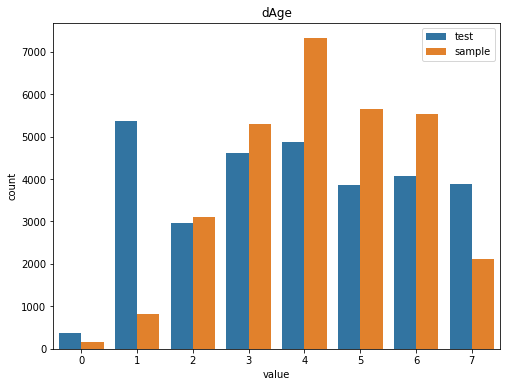

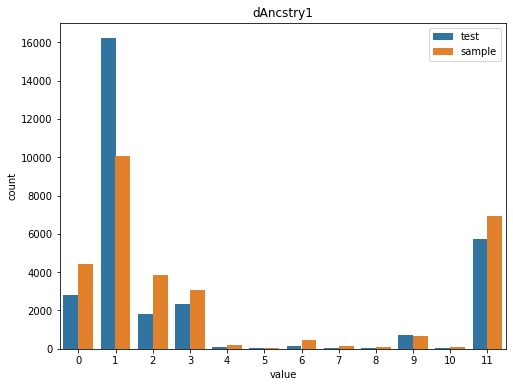

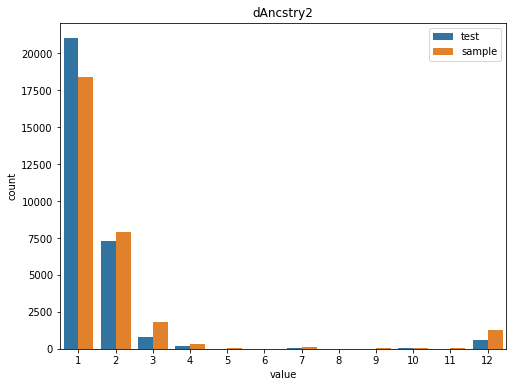

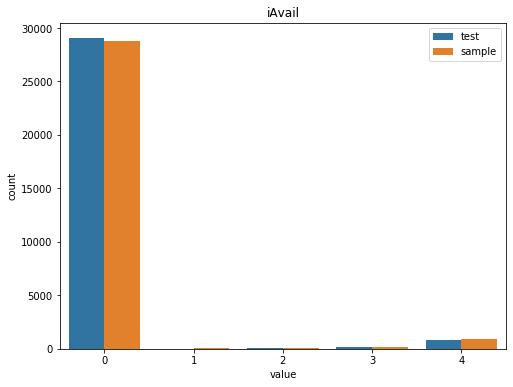

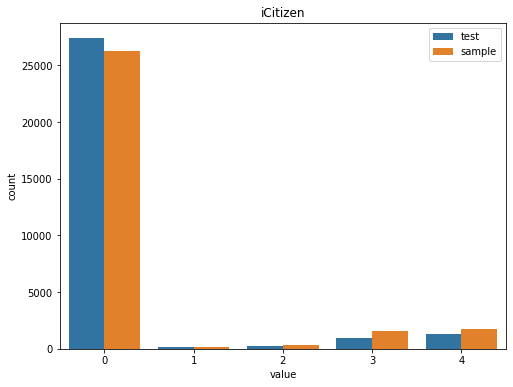

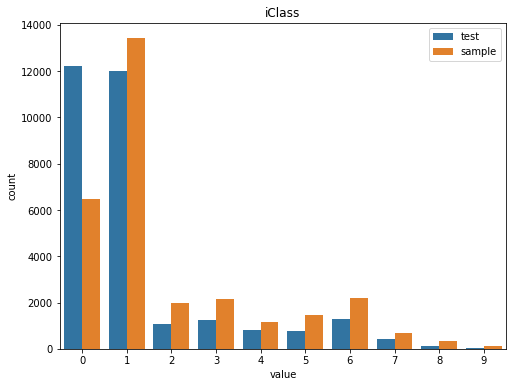

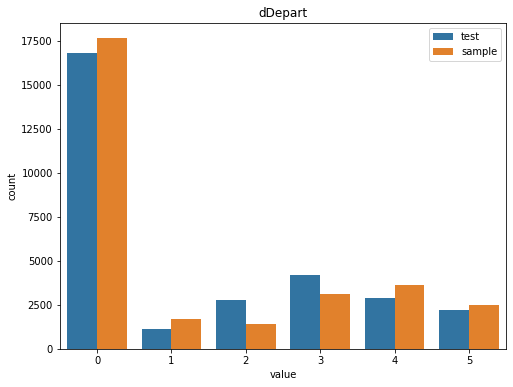

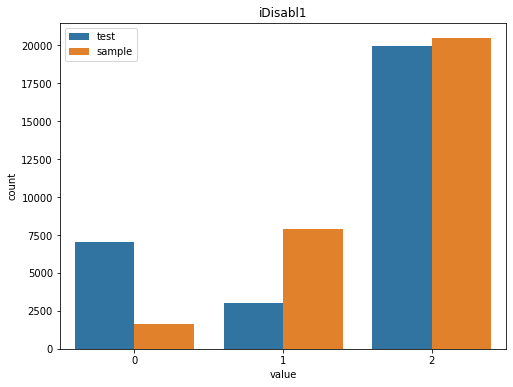

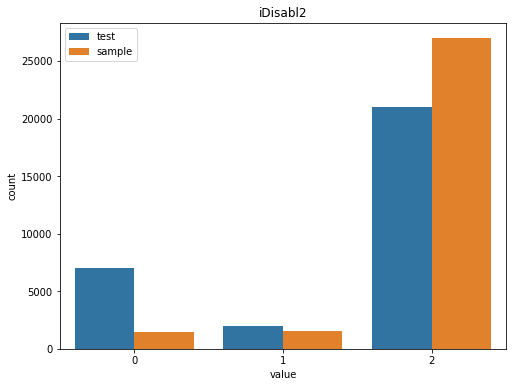

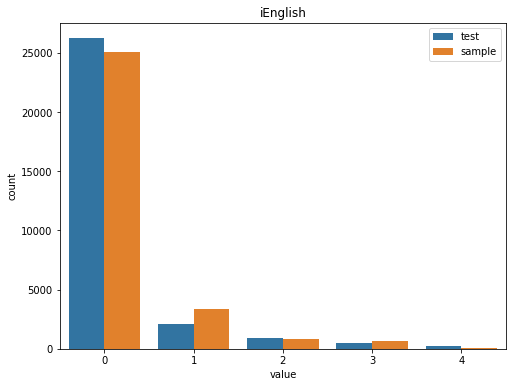

In [181]:
for col in all_variables:
    plot_table=pd.DataFrame()
    plot_table["test"] = test_dedummified[col]
    plot_table["sample"] = sample_dedummified[col]
    molten=pd.melt(plot_table)
    plt.figure(figsize=[8, 6])
    sns.countplot(data=molten, hue="variable", x="value")
    plt.title(str(col))
    plt.legend()
    

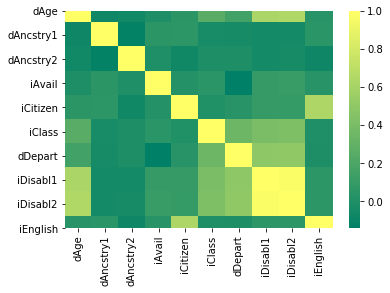

In [183]:
corr = test_dedummified.corr()
sns.heatmap(corr, cmap='summer', annot_kws={'size':20})
#ax1.set_title("Test df Correlation Matrix", fontsize=10)

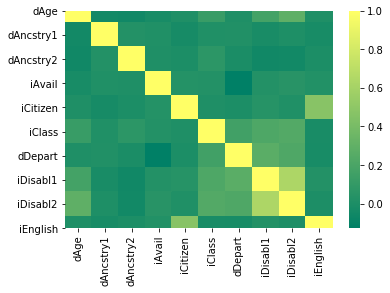

In [185]:
corr_2 = sample_dedummified.corr()
sns.heatmap(corr_2, cmap='summer', annot_kws={'size':20})
#ax1.set_title("Sampled df Correlation Matrix", fontsize=10)

Text(0.5, 1, 'Difference in correlations')

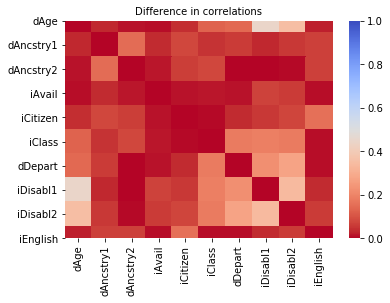

In [186]:
ax=sns.heatmap(abs(corr- corr_2), cmap='coolwarm_r', vmin=0, vmax=1, annot_kws={'size':10})
ax.set_title("Difference in correlations", fontsize=10)


In [187]:
print((abs(corr- corr_2).max().max()))

0.44890324636332224


The distribution plot show that the model performs better with variables that are more concentrated, that is, that have one or two levels that contain most observations (e.g. dAncestry2) whereas its performance suffers for variables that are more evenly distributed (e.g. dAge). This is expected because the chosen (smaller) sample size, and the fact that the parameters are ot tuned. The temperature parameter could help to better isolate the levels of each variables in an input distribution. 

Qualitatively the correlation matrices look similar, this can also be seen by looking at the third matrix: for each pair of variables we see that the highest difference in correlations is about 0.26, out of a maximum possible of 1.


Finally, following [3] we calculate, the frequency of each level of each variable in the test set and in the sample set. We get two vectors of dimension 69 (the number of binary variables after dummification) and compute the MSE between them.

In [188]:
compute_frequencies= lambda col: (test_df[col].sum()/test_df[col].count(),sample[col].sum()/sample[col].count())
scores =  list(map(compute_frequencies, test_df.columns))

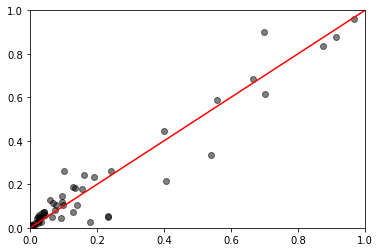

In [189]:
lineStart = 0
lineEnd = 1

plt.figure()
plt.scatter(*zip(*scores), color = 'k', alpha=0.5)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.show()

In [292]:
scores_1 = [x[0] for x in scores]
scores_2 = [x[1] for x in scores]
mean_squared_error(scores_1, scores_2)

0.002711347890499194

Possible improvements:
 - test several methods (as tested in [3]) how the correlation of the variables in the sample set compares to that observed in the test set. 
 One could fit a multiclass classification model (for example Random Forest) on both Test and Sample as training sets (or subsets of them), taking in turn each categorical variable as response and the remaining as predictors (in this example, that would make 10 models per sample). Then one could compare the characteristics of each model (feature importance, performance scores...) and see if corresponding model have similar characteristics.  
 - tune parameters
 - experiment different reparametrization tricks, distributions for sampling, ... 